In [ ]:
# !git clone https://github.com/broccubali/DLG-Assignments.git

fatal: destination path 'DLG-Assignments' already exists and is not an empty directory.


In [1]:
# !pip install torch_geometric

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import torch
from torch_geometric.nn import HypergraphConv
import networkx as nx

In [4]:
train_data = pd.read_csv('train_stock_data.csv')
train_data['Date'] = pd.to_datetime(train_data['Date'], format='%Y-%m-%d')
train_data.sort_values(['Ticker', 'Date'], inplace=True)

In [5]:
train_data

,Date,Ticker,Open,Open.1,Open.2,Open.3,Open.4,Open.5,Open.6,Open.7,...,Volume.10,Volume.11,Volume.12,Volume.13,Volume.14,Volume.15,Volume.16,Volume.17,Volume.18,Volume.19
0,2019-01-02,AAPL,36.944462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-03,AAPL,34.342203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-04,AAPL,34.473390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-07,AAPL,35.468021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-08,AAPL,35.673153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11083,2022-12-23,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11539400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11084,2022-12-27,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11962100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11085,2022-12-28,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10702100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11086,2022-12-29,XOM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10534000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
validation_data = pd.read_csv('validation_stock_data.csv')
with open('hyperedges.json', 'r') as f:
    hyperedges = json.load(f)
with open('blind_test_cases.json', 'r') as f:
    test_cases = json.load(f)

In [7]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Number of hyperedges: {len(hyperedges)}")
print(f"Number of test cases: {len(test_cases)}")
print("Training data columns:")
print(train_data.columns)

Training data shape: (20160, 102)
Validation data shape: (2000, 102)
Number of hyperedges: 8
Number of test cases: 120
Training data columns:
Index(['Date', 'Ticker', 'Open', 'Open.1', 'Open.2', 'Open.3', 'Open.4',
       'Open.5', 'Open.6', 'Open.7',
       ...
       'Volume.10', 'Volume.11', 'Volume.12', 'Volume.13', 'Volume.14',
       'Volume.15', 'Volume.16', 'Volume.17', 'Volume.18', 'Volume.19'],
      dtype='object', length=102)


In [8]:
print("Hyperedges structure:")
print(hyperedges)

print(type(hyperedges))

print("Available tickers in training data:", train_data['Ticker'].unique())

print("Test case example:")
test_cases[0]

Hyperedges structure:
{'Tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'], 'Finance': ['JPM', 'BAC', 'C'], 'Healthcare': ['JNJ', 'PFE', 'MRK'], 'Energy': ['XOM', 'CVX'], 'Consumer': ['WMT', 'PG', 'KO'], 'Industrials': ['BA', 'CAT'], 'Communications': ['VZ', 'T'], 'Utilities': ['DUK']}
<class 'dict'>
Available tickers in training data: ['AAPL' 'AMZN' 'BA' 'BAC' 'C' 'CAT' 'CVX' 'DUK' 'GOOGL' 'JNJ' 'JPM' 'KO'
 'MRK' 'MSFT' 'PFE' 'PG' 'T' 'VZ' 'WMT' 'XOM']
Test case example:


{'ticker': 'GOOGL',
 'date': '2023-03-01',
 'predicted_open': None,
 'predicted_high': None,
 'predicted_low': None,
 'predicted_close': None,
 'predicted_volume': None,
 'eval_metric': 'MAPE'}

In [9]:
l = []
tickers = train_data['Ticker'].unique()
for ticker in tickers:
    data = train_data[train_data["Ticker"] == ticker]
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
df

,Date,Ticker,Open,High,Low,Close,Volume
0,2019-01-02,AAPL,36.944462,37.889005,36.787037,37.667179,148158800.0
1,2019-01-03,AAPL,34.342203,34.757230,33.869933,33.915253,365248800.0
2,2019-01-04,AAPL,34.473390,35.432244,34.299271,35.363071,234428400.0
3,2019-01-07,AAPL,35.468021,35.499030,34.800162,35.284359,219111200.0
4,2019-01-08,AAPL,35.673153,36.212212,35.425093,35.956993,164101200.0
...,...,...,...,...,...,...,...
20155,2022-12-23,XOM,99.121032,100.780001,99.074697,100.724396,11539400.0
20156,2022-12-27,XOM,101.271219,102.383381,100.863433,102.123878,11962100.0
20157,2022-12-28,XOM,101.864365,101.947773,100.001499,100.446358,10702100.0
20158,2022-12-29,XOM,100.084912,101.688276,100.084912,101.206337,10534000.0


In [10]:
import pandas as pd

df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Volatility'] = df.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True)
df['Momentum'] = df.groupby('Ticker')['Close'].pct_change(periods=5)
df['Moving_Avg'] = df.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)

df.fillna(0, inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Volatility', 'Momentum', 'Moving_Avg']
df

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility,Momentum,Moving_Avg
0,2019-01-02,AAPL,36.944462,37.889005,36.787037,37.667179,148158800.0,0.000000,0.000000,0.000000,0.000000
1,2019-01-03,AAPL,34.342203,34.757230,33.869933,33.915253,365248800.0,-0.099607,0.000000,0.000000,0.000000
2,2019-01-04,AAPL,34.473390,35.432244,34.299271,35.363071,234428400.0,0.042689,0.000000,0.000000,0.000000
3,2019-01-07,AAPL,35.468021,35.499030,34.800162,35.284359,219111200.0,-0.002226,0.000000,0.000000,0.000000
4,2019-01-08,AAPL,35.673153,36.212212,35.425093,35.956993,164101200.0,0.019063,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20155,2022-12-23,XOM,99.121032,100.780001,99.074697,100.724396,11539400.0,0.026445,0.015932,0.038013,101.010784
20156,2022-12-27,XOM,101.271219,102.383381,100.863433,102.123878,11962100.0,0.013894,0.015044,0.047732,100.922739
20157,2022-12-28,XOM,101.864365,101.947773,100.001499,100.446358,10702100.0,-0.016426,0.015294,0.015840,100.768581
20158,2022-12-29,XOM,100.084912,101.688276,100.084912,101.206337,10534000.0,0.007566,0.015311,0.010550,100.616277


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

df[feature_cols] = scaler.fit_transform(df[feature_cols])
df

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility,Momentum,Moving_Avg
0,2019-01-02,AAPL,-0.861697,-0.853122,-0.858536,-0.850816,3.706484,0.000000,0.000000,0.000000,0.000000
1,2019-01-03,AAPL,-0.901195,-0.900113,-0.903358,-0.907771,10.402351,-0.099607,0.000000,0.000000,0.000000
2,2019-01-04,AAPL,-0.899204,-0.889984,-0.896761,-0.885793,6.367361,0.042689,0.000000,0.000000,0.000000
3,2019-01-07,AAPL,-0.884107,-0.888982,-0.889065,-0.886988,5.894921,-0.002226,0.000000,0.000000,0.000000
4,2019-01-08,AAPL,-0.880993,-0.878281,-0.879463,-0.876777,4.198207,0.019063,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
20155,2022-12-23,XOM,0.082058,0.090535,0.098521,0.106399,-0.507369,0.026445,0.015932,0.038013,101.010784
20156,2022-12-27,XOM,0.114695,0.114593,0.126005,0.127643,-0.494331,0.013894,0.015044,0.047732,100.922739
20157,2022-12-28,XOM,0.123698,0.108057,0.112762,0.102178,-0.533194,-0.016426,0.015294,0.015840,100.768581
20158,2022-12-29,XOM,0.096688,0.104164,0.114043,0.113715,-0.538379,0.007566,0.015311,0.010550,100.616277


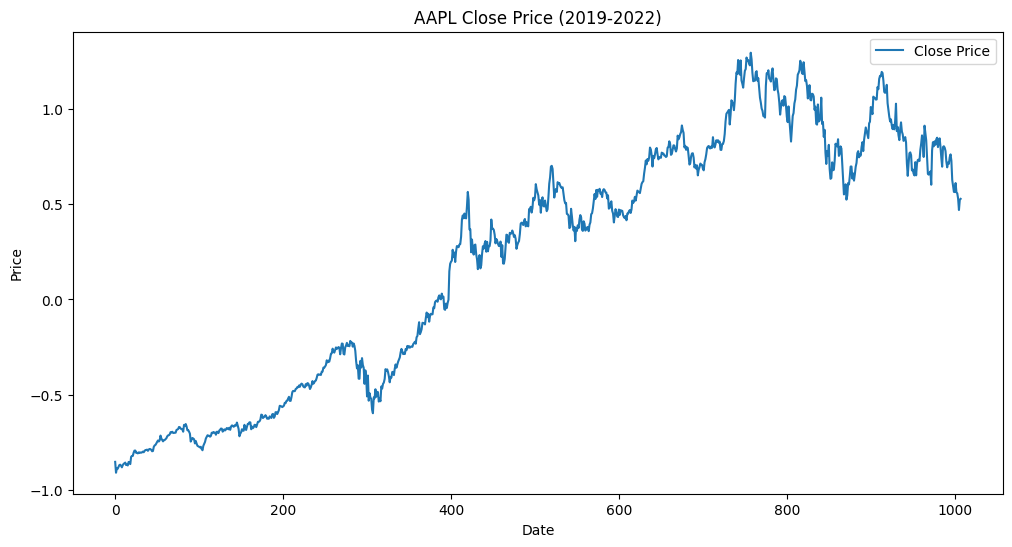

In [12]:
aapl = df[df["Ticker"] == "AAPL"]
plt.figure(figsize=(12, 6))
plt.plot(aapl.index, aapl['Close'], label='Close Price')
plt.title('AAPL Close Price (2019-2022)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [13]:
stocks = ['AAPL', 'AMZN', 'BA', 'BAC', 'C', 'CAT', 'CVX', 'DUK', 'GOOGL', 'JNJ', 'JPM' ,'KO', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'VZ', 'WMT', 'XOM']

ticker_to_idx = {ticker: idx for idx, ticker in enumerate(sorted(tickers))}
print("Ticker to index mapping:", ticker_to_idx)

Ticker to index mapping: {'AAPL': 0, 'AMZN': 1, 'BA': 2, 'BAC': 3, 'C': 4, 'CAT': 5, 'CVX': 6, 'DUK': 7, 'GOOGL': 8, 'JNJ': 9, 'JPM': 10, 'KO': 11, 'MRK': 12, 'MSFT': 13, 'PFE': 14, 'PG': 15, 'T': 16, 'VZ': 17, 'WMT': 18, 'XOM': 19}


In [14]:
hyperedge_indices = []
for he_name, tickers in hyperedges.items():
    indices = [ticker_to_idx[t] for t in tickers]
    print(f"Hyperedge '{he_name}': {tickers} -> {indices}")
    hyperedge_indices.append(indices)

Hyperedge 'Tech': ['AAPL', 'GOOGL', 'MSFT', 'AMZN'] -> [0, 8, 13, 1]
Hyperedge 'Finance': ['JPM', 'BAC', 'C'] -> [10, 3, 4]
Hyperedge 'Healthcare': ['JNJ', 'PFE', 'MRK'] -> [9, 14, 12]
Hyperedge 'Energy': ['XOM', 'CVX'] -> [19, 6]
Hyperedge 'Consumer': ['WMT', 'PG', 'KO'] -> [18, 15, 11]
Hyperedge 'Industrials': ['BA', 'CAT'] -> [2, 5]
Hyperedge 'Communications': ['VZ', 'T'] -> [17, 16]
Hyperedge 'Utilities': ['DUK'] -> [7]


In [15]:
hyperedge_indices

[[0, 8, 13, 1],
 [10, 3, 4],
 [9, 14, 12],
 [19, 6],
 [18, 15, 11],
 [2, 5],
 [17, 16],
 [7]]

## clique representation

In [16]:
adj_matrix = [[0 for i in range(20)] for j in range(20)]
for hyperedge in hyperedge_indices:
    for i in range(len(hyperedge)):
        for j in range(i+1, len(hyperedge)):
            adj_matrix[hyperedge[i]][hyperedge[j]] = 1
            adj_matrix[hyperedge[j]][hyperedge[i]] = 1
adj_matrix = np.array(adj_matrix)
adj_matrix

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [17]:
import torch
edge_index = torch.tensor(np.array(np.nonzero(adj_matrix)), dtype=torch.long)
edge_index

tensor([[ 0,  0,  0,  1,  1,  1,  2,  3,  3,  4,  4,  5,  6,  8,  8,  8,  9,  9,
         10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14, 15, 15, 16, 17, 18, 18, 19],
        [ 1,  8, 13,  0,  8, 13,  5,  4, 10,  3, 10,  2, 19,  0,  1, 13, 12, 14,
          3,  4, 15, 18,  9, 14,  0,  1,  8,  9, 12, 11, 18, 17, 16, 11, 15,  6]])

In [18]:
def get_features_for_date(df, date, tickers, feature_cols):
    day_df = df[df['Date'] == date].set_index('Ticker')
    day_df = day_df.reindex(tickers)
    x = day_df[feature_cols].fillna(0).values
    y = day_df[['Open', 'High', 'Low', 'Close', 'Volume']].fillna(0).values
    return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

dates = sorted(df['Date'].unique())
graph_snapshots = []
tickers = sorted(df['Ticker'].unique())
for date in dates:
    x_t, y_t = get_features_for_date(df, date, tickers, features)
    graph_snapshots.append((x_t, y_t))

In [19]:
graph_snapshots[100]

(tensor([[-7.6941e-01, -7.7004e-01, -7.6643e-01, -7.7201e-01,  2.5848e+00,
          -4.1348e-03,  1.9073e-02, -2.6544e-02,  4.7313e+01],
         [-3.1532e-02, -3.4251e-02, -1.9901e-02, -2.8748e-02,  1.1107e+00,
           7.2123e-03,  1.4555e-02, -1.2125e-02,  9.4302e+01],
         [ 3.8743e+00,  3.8737e+00,  3.9319e+00,  3.8686e+00, -7.5520e-01,
          -5.6469e-05,  1.5538e-02,  5.9242e-03,  3.5717e+02],
         [-1.0553e+00, -1.0561e+00, -1.0543e+00, -1.0574e+00,  5.0227e-01,
          -9.9361e-03,  1.2517e-02, -1.7606e-02,  2.5418e+01],
         [-6.3572e-01, -6.3954e-01, -6.3146e-01, -6.3947e-01, -4.0904e-01,
          -9.3183e-03,  1.6219e-02, -1.8011e-02,  5.4581e+01],
         [ 2.1735e-01,  2.0677e-01,  2.1742e-01,  1.9989e-01, -7.1248e-01,
          -1.0659e-02,  1.6397e-02, -6.8610e-03,  1.1680e+02],
         [-2.1897e-02, -3.1995e-02, -1.4466e-02, -2.8621e-02, -6.1206e-01,
          -3.3695e-03,  1.2451e-02, -2.0937e-02,  9.2179e+01],
         [-3.5556e-01, -3.6648e-01

In [20]:
from torch_geometric.data import Data

graphs = []

for x_t, y_t in graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    graphs.append(graph)

In [21]:
graphs[0]

Data(x=[20, 9], edge_index=[2, 36], y=[20, 5])

In [22]:
val_data = pd.read_csv('validation_stock_data.csv')
val_data['Date'] = pd.to_datetime(val_data['Date'], format='%Y-%m-%d')
val_data.sort_values(['Ticker', 'Date'], inplace=True)
l = []
val_tickers = sorted(val_data['Ticker'].unique())
for ticker in val_tickers:
    data = val_data[val_data["Ticker"] == ticker]
    valid_cols = []
    for i in data.columns:
        if data[i].isna().sum() == 0:
            valid_cols.append(i)
    a = data[valid_cols].values
    for i in a:
        l.append(i)
df1 = pd.DataFrame(l, columns=["Date", "Ticker", "Open", "High", "Low", "Close", "Volume"])
df1

,Date,Ticker,Open,High,Low,Close,Volume
0,2023-01-03,AAPL,128.782649,129.395518,122.742873,123.632530,112117500.0
1,2023-01-04,AAPL,125.431607,127.181268,123.642412,124.907700,89113600.0
2,2023-01-05,AAPL,125.668857,126.301500,123.326101,123.583107,80962700.0
3,2023-01-06,AAPL,124.561702,128.792501,123.454572,128.130203,87754700.0
4,2023-01-09,AAPL,128.970458,131.876670,128.397123,128.654129,70790800.0
...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,98.058076,98.661898,97.588442,97.674706,12921800.0
1996,2023-12-26,XOM,98.470205,98.748153,97.875976,97.895142,16835100.0
1997,2023-12-27,XOM,97.799294,98.288101,97.128381,97.435089,14558800.0
1998,2023-12-28,XOM,97.176310,97.387168,95.968673,96.026184,16329300.0


In [23]:
import pandas as pd

df1['Return'] = df1.groupby('Ticker')['Close'].pct_change()
df1['Volatility'] = df1.groupby('Ticker')['Return'].rolling(window=30).std().reset_index(0, drop=True)
df1['Momentum'] = df1.groupby('Ticker')['Close'].pct_change(periods=5)
df1['Moving_Avg'] = df1.groupby('Ticker')['Close'].rolling(window=30).mean().reset_index(0, drop=True)

df1.fillna(0, inplace=True)

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'Volatility', 'Momentum', 'Moving_Avg']
df1

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility,Momentum,Moving_Avg
0,2023-01-03,AAPL,128.782649,129.395518,122.742873,123.632530,112117500.0,0.000000,0.000000,0.000000,0.000000
1,2023-01-04,AAPL,125.431607,127.181268,123.642412,124.907700,89113600.0,0.010314,0.000000,0.000000,0.000000
2,2023-01-05,AAPL,125.668857,126.301500,123.326101,123.583107,80962700.0,-0.010605,0.000000,0.000000,0.000000
3,2023-01-06,AAPL,124.561702,128.792501,123.454572,128.130203,87754700.0,0.036794,0.000000,0.000000,0.000000
4,2023-01-09,AAPL,128.970458,131.876670,128.397123,128.654129,70790800.0,0.004089,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,98.058076,98.661898,97.588442,97.674706,12921800.0,0.001769,0.011277,0.010010,97.892264
1996,2023-12-26,XOM,98.470205,98.748153,97.875976,97.895142,16835100.0,0.002257,0.011193,0.004820,97.870862
1997,2023-12-27,XOM,97.799294,98.288101,97.128381,97.435089,14558800.0,-0.004699,0.011037,-0.012914,97.799618
1998,2023-12-28,XOM,97.176310,97.387168,95.968673,96.026184,16329300.0,-0.014460,0.011282,-0.010665,97.668631


In [70]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

df1[feature_cols] = scaler.transform(df1[feature_cols])
df1

,Date,Ticker,Open,High,Low,Close,Volume,Return,Volatility,Momentum,Moving_Avg
0,2023-01-03,AAPL,-1.419675,-1.419031,-1.422268,-1.421191,-0.863287,0.000000,0.000000,0.000000,0.000000
1,2023-01-04,AAPL,-1.420550,-1.419597,-1.422028,-1.420859,-0.863287,0.010314,0.000000,0.000000,0.000000
2,2023-01-05,AAPL,-1.420488,-1.419821,-1.422112,-1.421204,-0.863287,-0.010605,0.000000,0.000000,0.000000
3,2023-01-06,AAPL,-1.420778,-1.419185,-1.422078,-1.420019,-0.863287,0.036794,0.000000,0.000000,0.000000
4,2023-01-09,AAPL,-1.419626,-1.418398,-1.420759,-1.419882,-0.863287,0.004089,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1995,2023-12-22,XOM,-1.427700,-1.426877,-1.428978,-1.427958,-0.863287,0.001769,0.011277,0.010010,97.892264
1996,2023-12-26,XOM,-1.427592,-1.426855,-1.428901,-1.427901,-0.863287,0.002257,0.011193,0.004820,97.870862
1997,2023-12-27,XOM,-1.427767,-1.426973,-1.429101,-1.428021,-0.863287,-0.004699,0.011037,-0.012914,97.799618
1998,2023-12-28,XOM,-1.427930,-1.427203,-1.429410,-1.428388,-0.863287,-0.014460,0.011282,-0.010665,97.668631


In [71]:
dates = sorted(df1['Date'].unique())
val_graph_snapshots = []

for date in dates:
    x_t, y_t = get_features_for_date(df1, date, tickers, features)
    val_graph_snapshots.append((x_t, y_t))

In [72]:
val_graph_snapshots[0][0].shape

torch.Size([20, 9])

In [73]:
val_graphs = []

for x_t, y_t in val_graph_snapshots:
    graph = Data(x=x_t, edge_index=edge_index, y=y_t)
    val_graphs.append(graph)
val_graphs[0]

Data(x=[20, 9], edge_index=[2, 36], y=[20, 5])

In [74]:
from torch_geometric.nn import GATConv
import torch.nn.functional as F

class StockGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=5, heads=2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [75]:
model = StockGAT(in_channels=len(features), hidden_channels=32, out_channels=5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
loss_fn = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [76]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(graphs, batch_size=1, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=1, shuffle=False)

In [77]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
edge_index = edge_index.to(device)
epochs = 20
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}] Training", leave=False):
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, batch.y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"[Epoch {epoch+1}] Validation", leave=False):
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index)
            loss = loss_fn(out, batch.y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step()
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1 | Train Loss: 18.5167 | Val Loss: 2.1078


Epoch 2 | Train Loss: 0.7778 | Val Loss: 0.8323


Epoch 3 | Train Loss: 0.5717 | Val Loss: 0.8601


Epoch 4 | Train Loss: 0.4883 | Val Loss: 0.9137


Epoch 5 | Train Loss: 0.4490 | Val Loss: 0.8437


Epoch 6 | Train Loss: 0.4222 | Val Loss: 0.6710


Epoch 7 | Train Loss: 0.4051 | Val Loss: 0.5088


Epoch 8 | Train Loss: 0.3995 | Val Loss: 0.4829


Epoch 9 | Train Loss: 0.3990 | Val Loss: 0.4698


Epoch 10 | Train Loss: 0.3985 | Val Loss: 0.4617


Epoch 11 | Train Loss: 0.3981 | Val Loss: 0.4527


Epoch 12 | Train Loss: 0.3977 | Val Loss: 0.4482


Epoch 13 | Train Loss: 0.3974 | Val Loss: 0.4448


Epoch 14 | Train Loss: 0.3972 | Val Loss: 0.4426


Epoch 15 | Train Loss: 0.3970 | Val Loss: 0.4428


Epoch 16 | Train Loss: 0.3970 | Val Loss: 0.4426


Epoch 17 | Train Loss: 0.3969 | Val Loss: 0.4427


Epoch 18 | Train Loss: 0.3969 | Val Loss: 0.4429


Epoch 19 | Train Loss: 0.3969 | Val Loss: 0.4425


Epoch 20 | Train Loss: 0.3969 | Val Loss: 0.4427


In [78]:
model.eval()
preds_list, actuals_list = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Making Predictions", leave=False):
        batch = batch.to(device)
        preds = model(batch.x, batch.edge_index)

        preds_list.append(preds.cpu())
        actuals_list.append(batch.y.cpu())

In [92]:
import numpy as np

preds = torch.cat(preds_list, dim=0)
actuals = torch.cat(actuals_list, dim=0) 

mask = actuals.abs().sum(dim=1) > 0

preds = preds[mask].numpy()
actuals = actuals[mask].numpy()

In [93]:
# preds = scaler.inverse_transform(preds)
# actuals = scaler.inverse_transform(actuals)
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(actuals, preds)
rmse = mean_squared_error(actuals, preds)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

MAE: 0.6792, RMSE: 0.5062


In [98]:
a = pd.DataFrame(preds, columns=["Open", "High", "Low", "Close", "Volume"])
b = pd.DataFrame(df1[["Open", "High", "Low", "Close", "Volume"]], columns=["Open", "High", "Low", "Close", "Volume"])

In [99]:
a

,Open,High,Low,Close,Volume
0,-0.414621,-0.362614,-0.331415,-0.429936,-0.148829
1,-0.594888,-0.669888,-0.512158,-0.610139,-0.378001
2,-0.963871,-1.331520,-0.894993,-0.946882,-0.880257
3,-0.474954,-0.464464,-0.391503,-0.491294,-0.223989
4,-0.476099,-0.466655,-0.393054,-0.492766,-0.223774
...,...,...,...,...,...
1995,-0.843252,-0.553690,-0.602326,-0.653665,-0.300287
1996,-0.826070,-0.549342,-0.596858,-0.651718,-0.305174
1997,-1.167381,-0.891637,-0.805128,-0.712987,-0.277171
1998,-1.105445,-0.708885,-0.656250,-0.608774,-0.143919


In [100]:
b

,Open,High,Low,Close,Volume
0,-1.419675,-1.419031,-1.422268,-1.421191,-0.863287
1,-1.420550,-1.419597,-1.422028,-1.420859,-0.863287
2,-1.420488,-1.419821,-1.422112,-1.421204,-0.863287
3,-1.420778,-1.419185,-1.422078,-1.420019,-0.863287
4,-1.419626,-1.418398,-1.420759,-1.419882,-0.863287
...,...,...,...,...,...
1995,-1.427700,-1.426877,-1.428978,-1.427958,-0.863287
1996,-1.427592,-1.426855,-1.428901,-1.427901,-0.863287
1997,-1.427767,-1.426973,-1.429101,-1.428021,-0.863287
1998,-1.427930,-1.427203,-1.429410,-1.428388,-0.863287


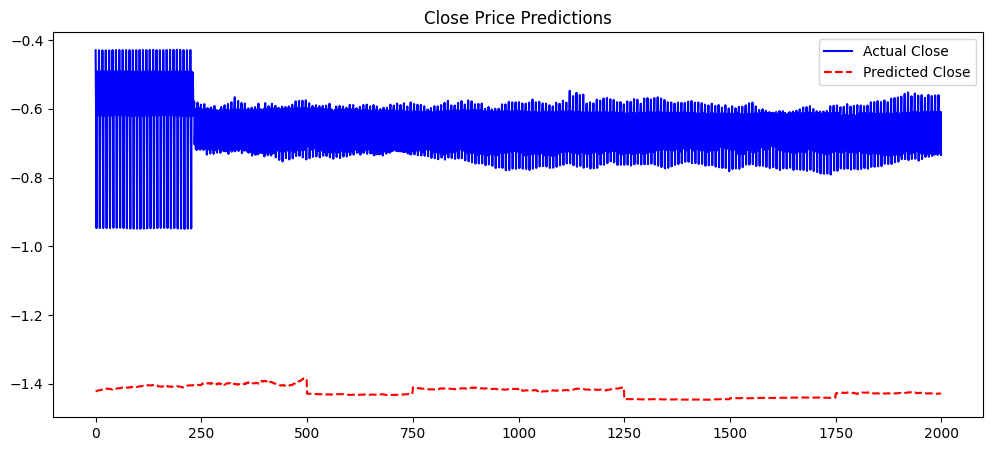

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(a.iloc[:, 3], label="Actual Close", color="blue")
plt.plot(b.iloc[:, 3], label="Predicted Close", color="red", linestyle="dashed")
plt.legend()
plt.title("Close Price Predictions")
plt.show()
